In [53]:
import gradio as gr
import plotly.graph_objects as go
import pandas as pd
import uuid
import pickle
import numpy as np
from pycox.models import CoxPH
from scipy.stats import norm

# Load your pickled DeepSurv model
with open("pickle/deepsurv_model_20250417_133745.pkl", "rb") as f:
    checkpoint = pickle.load(f)


# Reconstruct CoxPH model and load weights
model = CoxPH(checkpoint['model_structure'])
model.net.load_state_dict(checkpoint['model_state_dict'])
model.baseline_hazards_ = checkpoint['baseline_hazards']
model.baseline_cumulative_hazards_ = checkpoint['baseline_cumulative_hazards']
model.net.eval()


ALPHA = 0.1
Z95 = norm.ppf(1-ALPHA/2)

# Predictor column order must match training
PREDS = [
    "age", "size", "nodes", "prog", "oest",
    "treat_1", "men_2", "grade_2", "grade_3"
]

# Globals for save
last_figure = None
last_table = None

# 95% CI z-value
# Complementary log-log CI width factor (adjustable)
treat, age, men, size, grade, nodes, prog, oest = 0, 70, 2, 21, 2, 3, 48, 66




# Early-exit if no inputs
inputs = [treat, age, men, size, grade, nodes, prog, oest]
if all(v in (None, 0) for v in inputs):
    last_figure = None
    last_table  = None

# Build feature row
row = pd.DataFrame([{
    "age":     age,
    "size":    size,
    "nodes":   nodes,
    "prog":    prog,
    "oest":    oest,
    "treat_1": int(treat),
    "men_2":   int(men == 2),
    "grade_2": int(grade == 2),
    "grade_3": int(grade == 3)
}])[PREDS].astype("float32")

# Apply same scaling used in training
row["age"]   /= 100.0
row["size"]  /= 100.0
row["nodes"] /= 10.0
row["prog"]  /= 1000.0
row["oest"]  /= 1000.0

# Predict survival and cumulative hazard
surv_df = model.predict_surv_df(row.values)
cumhaz  = model.predict_cumulative_hazards(row.values)

# Extract arrays
times = surv_df.index.values
S_hat = surv_df.values[:, 0]
H_hat = cumhaz.values[:, 0]


S_CL = 0.1/(S_hat * np.abs(np.log(S_hat)))
lower_S = np.maximum(0.0, S_hat **np.exp(-Z95 * S_CL))
upper_S = np.minimum(1.0, S_hat **np.exp( Z95 * S_CL))
lower_H = H_hat * np.exp(-Z95 * S_CL)
upper_H = H_hat * np.exp( Z95 * S_CL)


/var/folders/b5/f8bb69ks1kxg53xxn3ff4frm0000gn/T/ipykernel_12783/3557227876.py:79: RuntimeWarning: divide by zero encountered in divide
  S_CL = 0.1/(S_hat * np.abs(np.log(S_hat)))
/var/folders/b5/f8bb69ks1kxg53xxn3ff4frm0000gn/T/ipykernel_12783/3557227876.py:83: RuntimeWarning: invalid value encountered in multiply
  upper_H = H_hat * np.exp( Z95 * S_CL)


In [57]:
S_CL

array([        inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf, 48.64052368, 48.64052368, 24.3182863 ,
       24.3182863 , 16.17722071, 12.12744312, 12.12744312,  9.69455094,
        8.07590137,  6.92149773,  6.92149773,  6.05415352,  5.38127045,
        5.38127045,  4.84343542,  4.40389367,  4.03809176,  3.72910391,
        3.72910391,  3.46411812,  3.46411812,  3.03282012,  2.69797078,
        2.5573971 ,  2.43084394,  2.43084394,  2.31596839,  2.21170064,
        2.11657505,  2.11657505,  2.02923035,  2.02923035,  1.94876914,
        1.87463403,  1.68359919,  1.62844201,  1.57680965,  1.52845841,
        1.48310684,  1.44029937,  1.39998701,  1.32599697,  1.29187222,
        1.25954123,  1.22886476,  1.19969088,  1.17193873,  1.14552183,
        1.12032425,  1.0962941 ,  1.07329161,  1.0513191 ,  1.03026428,
        1.01006724,  0.99070618,  0.97211365,  0.95428095,  0.93

In [59]:
np.exp( Z95 * S_CL)

array([           inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
       5.57698678e+34, 5.57698678e+34, 2.35390309e+17, 2.35390309e+17,
       3.59924512e+11, 4.60520904e+08, 4.60520904e+08, 8.41997382e+06,
       5.87525925e+05, 8.79787558e+04, 8.79787558e+04, 2.11246602e+04,
       6.98417542e+03, 6.98417542e+03, 2.88344869e+03, 1.39934629e+03,
       7.66680283e+02, 4.61199219e+02, 4.61199219e+02, 2.98260497e+02,
       2.98260497e+02, 1.46722812e+02, 8.45858523e+01, 6.71241509e+01,
       5.45099072e+01, 5.45099072e+01, 4.51246658e+01, 3.80128332e+01,
       3.25070224e+01, 3.25070224e+01, 2.81567439e+01, 2.81567439e+01,
       2.46663504e+01, 2.18346593e+01, 1.59470559e+01, 1.45639419e+01,
       1.33781272e+01, 1.23553646e+01, 1.14672330e+01, 1.06875727e+01,
       1.00018863e+01, 8.85578503e+00, 8.37240108e+00, 7.93879070e+00,
      

In [60]:
S_hat np.exp( Z95 * S_CL)

array([           inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
       5.57698678e+34, 5.57698678e+34, 2.35390309e+17, 2.35390309e+17,
       3.59924512e+11, 4.60520904e+08, 4.60520904e+08, 8.41997382e+06,
       5.87525925e+05, 8.79787558e+04, 8.79787558e+04, 2.11246602e+04,
       6.98417542e+03, 6.98417542e+03, 2.88344869e+03, 1.39934629e+03,
       7.66680283e+02, 4.61199219e+02, 4.61199219e+02, 2.98260497e+02,
       2.98260497e+02, 1.46722812e+02, 8.45858523e+01, 6.71241509e+01,
       5.45099072e+01, 5.45099072e+01, 4.51246658e+01, 3.80128332e+01,
       3.25070224e+01, 3.25070224e+01, 2.81567439e+01, 2.81567439e+01,
       2.46663504e+01, 2.18346593e+01, 1.59470559e+01, 1.45639419e+01,
       1.33781272e+01, 1.23553646e+01, 1.14672330e+01, 1.06875727e+01,
       1.00018863e+01, 8.85578503e+00, 8.37240108e+00, 7.93879070e+00,
      

In [5]:
surv_df

,0
duration,
8.0,1.000000
15.0,1.000000
16.0,1.000000
17.0,1.000000
18.0,1.000000
...,...
2551.0,0.386843
2556.0,0.386843
2563.0,0.386843


In [8]:
surv_df.iloc[1:]

,0
duration,
15.0,1.000000
16.0,1.000000
17.0,1.000000
18.0,1.000000
42.0,1.000000
...,...
2551.0,0.386843
2556.0,0.386843
2563.0,0.386843


In [31]:
S_CL = 0.1/(S_hat * np.abs(np.log(S_hat)))
#S_CL[S_CL == np.inf] = 0

lower_S = np.maximum(0.0, S_hat**np.exp(-Z95 * S_CL))
upper_S = np.minimum(1.0, S_hat**np.exp( Z95 * S_CL))

lower_S[] = 1
upper_S[S_CL==np.inf] = 1

/var/folders/b5/f8bb69ks1kxg53xxn3ff4frm0000gn/T/ipykernel_12783/2207735109.py:1: RuntimeWarning: divide by zero encountered in divide
  S_CL = 0.1/(S_hat * np.abs(np.log(S_hat)))


In [50]:
S_hat = 0.99794198
upper_S = S_hat**np.exp(1.96 * 0.1/(S_hat * np.abs(np.log(S_hat))))

In [51]:
lower_S = S_hat**np.exp(-1.96 * 0.1/(S_hat * np.abs(np.log(S_hat))))

In [52]:
upper_S

0.0

In [33]:
S_CL

array([        inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf, 48.64052368, 48.64052368, 24.3182863 ,
       24.3182863 , 16.17722071, 12.12744312, 12.12744312,  9.69455094,
        8.07590137,  6.92149773,  6.92149773,  6.05415352,  5.38127045,
        5.38127045,  4.84343542,  4.40389367,  4.03809176,  3.72910391,
        3.72910391,  3.46411812,  3.46411812,  3.03282012,  2.69797078,
        2.5573971 ,  2.43084394,  2.43084394,  2.31596839,  2.21170064,
        2.11657505,  2.11657505,  2.02923035,  2.02923035,  1.94876914,
        1.87463403,  1.68359919,  1.62844201,  1.57680965,  1.52845841,
        1.48310684,  1.44029937,  1.39998701,  1.32599697,  1.29187222,
        1.25954123,  1.22886476,  1.19969088,  1.17193873,  1.14552183,
        1.12032425,  1.0962941 ,  1.07329161,  1.0513191 ,  1.03026428,
        1.01006724,  0.99070618,  0.97211365,  0.95428095,  0.93

In [34]:
upper_S

array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 7.85945246e-155,
       3.60326417e-058, 3.60326417e-058, 3.92746578e-027, 7.51146822e-015,
       3.48550231e-009, 3.01104690e-006, 3.01104690e-006, 1.40557516e-004,
       1.40557516e-004, 6.69942043e-003, 3.84540993e-002, 6.49712306e-002,
       9.62485399e-002, 9.62485399e-002, 1.30230403e-001, 1.64942136e-001,
       1.99087277e-001, 1.99087277e-001, 2.31892551e-001, 2.31892551e-001,
       2.62843270e-001, 2.91599945e-001, 3.64556918e-001, 3.84829150e-001,
       4.03324080e-001, 4.20157842e-001, 4.35472050e-001, 4.49467901e-001,
       4.62210957e-001, 4

In [35]:
lower_S

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999998, 0.99999983, 0.99999983, 0.9999992 , 0.99999729,
       0.99999729, 0.99999269, 0.99998339, 0.99996687, 0.99994023,
       0.99994023, 0.9999003 , 0.9999003 , 0.9997675 , 0.9995447 ,
       0.99939343, 0.99921251, 0.99921251, 0.99899941, 0.99875359,
       0.99847377, 0.99847377, 0.99815826, 0.99815826, 0.99780627,
       0.99741841, 0.99603996, 0.99550791, 0.99493941, 0.99433581,
       0.99369796, 0.99302339, 0.99231525, 0.99080036, 0.98999265,
       0.98915409, 0.9882854 , 0.9873864 , 0.98645868, 0.98550355,
       0.98452088, 0.98351269, 0.98247693, 0.9814175 , 0.98033277,
       0.97922313, 0.97809094, 0.97693579, 0.9757607 , 0.97456144,
       0.97333864, 0.97209622, 0.97209622, 0.97209622, 0.97082

In [36]:
import matplotlib.pyplot as plt

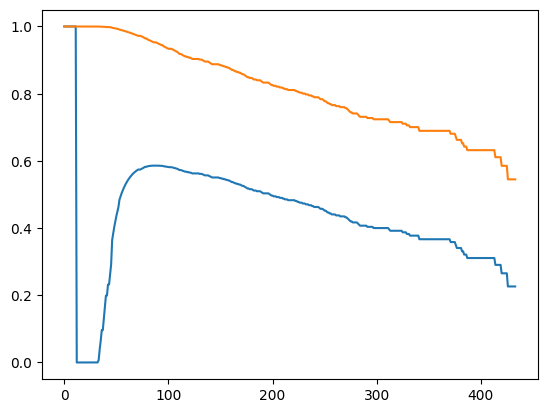

In [37]:
plt.plot(upper_S)
plt.plot(lower_S)

In [39]:
upper_S

array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 7.85945246e-155,
       3.60326417e-058, 3.60326417e-058, 3.92746578e-027, 7.51146822e-015,
       3.48550231e-009, 3.01104690e-006, 3.01104690e-006, 1.40557516e-004,
       1.40557516e-004, 6.69942043e-003, 3.84540993e-002, 6.49712306e-002,
       9.62485399e-002, 9.62485399e-002, 1.30230403e-001, 1.64942136e-001,
       1.99087277e-001, 1.99087277e-001, 2.31892551e-001, 2.31892551e-001,
       2.62843270e-001, 2.91599945e-001, 3.64556918e-001, 3.84829150e-001,
       4.03324080e-001, 4.20157842e-001, 4.35472050e-001, 4.49467901e-001,
       4.62210957e-001, 4